In [1]:
import igraph as ig
import leidenalg as la
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import sys
sys.path.append('../')
from src.graph_utilities import lcc_excluding_no_content

In [2]:
# with open('../data/Cit-HepPh.txt', 'r') as f:
#     for _ in range(4):
#         f.readline()
#     edges = []
#     while True:
#         line = f.readline()
#         if not line:
#             break
#         edges.append(line.split())
        
# # generate synthetic labels
# labels = ('agreement', 'neutral', 'disagreement')
# for i in range(len(edges)):
#     label = random.choice(labels)
#     edges[i].append(label)

# # generate synthetic embeddings
# nodes = set()
# for edge in edges:
#     nodes.add(edge[0])
#     nodes.add(edge[1])
# nodes = list(nodes)

# embeddings = {node: np.random.rand(10) for node in nodes}

# # convert to graph
# g = ig.Graph.TupleList(edges, directed=True, edge_attrs=['label'])
# g.vs['embedding'] = [embeddings[node] for node in g.vs['name']]

In [3]:
labels = ['agreement', 'neutral', 'disagreement']
g = lcc_excluding_no_content()
g.vs['embedding'] = np.random.rand(g.vcount(), 10)
g.es['label'] = np.random.choice(labels, g.ecount())

In [4]:
# compute average distance between nodes of the same label
for label in labels:
    print(label)
    distances = []
    es = g.es.select(label_eq=label)
    for edge in es:
        u = g.vs[edge.source]
        v = g.vs[edge.target]
        distances.append(np.linalg.norm(u['embedding'] - v['embedding']))
    print(np.mean(distances))

agreement
1.2668449428891557
neutral
1.2662706647760504
disagreement
1.2657855037297876


In [5]:
g.es.select(label_eq='agreement')['color'] = 'green'
g.es.select(label_eq='neutral')['color'] = 'gray'
g.es.select(label_eq='disagreement')['color'] = 'red'

In [6]:
def get_degree_sequence(label):
    _, in_degrees = np.unique([edge.source for edge in g.es.select(label_eq=label)], return_counts=True)
    _, out_degrees = np.unique([edge.target for edge in g.es.select(label_eq=label)], return_counts=True)
    
    d_in, v_in = np.unique(in_degrees, return_counts=True)
    v_in = v_in / v_in.sum()
    d_out, v_out = np.unique(out_degrees, return_counts=True)
    v_out = v_out / v_out.sum()
    
    return d_in, v_in, d_out, v_out

a_d_in, a_v_in, a_d_out, a_v_out = get_degree_sequence('agreement')
n_d_in, n_v_in, n_d_out, n_v_out = get_degree_sequence('neutral')
d_d_in, d_v_in, d_d_out, d_v_out = get_degree_sequence('disagreement')

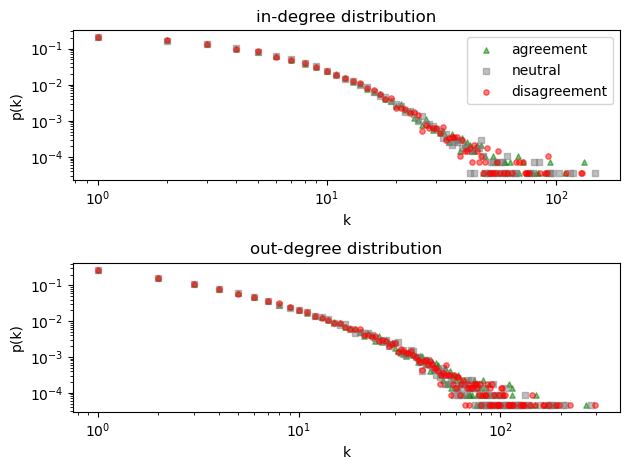

In [7]:
dot_size = 15

fig, (ax1, ax2) = plt.subplots(2)

# plot in-degree
ax1.scatter(a_d_in, a_v_in, s=dot_size, color='green', label='agreement', alpha=0.5, marker='^')
ax1.scatter(n_d_in, n_v_in, s=dot_size, color='gray', label='neutral', alpha=0.5, marker='s')
ax1.scatter(d_d_in, d_v_in, s=dot_size, color='red', label='disagreement', alpha=0.5, marker='o')
ax1.set_xlabel('k')
ax1.set_ylabel('p(k)')
ax1.set_title(f'in-degree distribution')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()

# plot out-degree
ax2.scatter(a_d_out, a_v_out, s=dot_size, color='green', label='agreement', alpha=0.5, marker='^')
ax2.scatter(n_d_out, n_v_out, s=dot_size, color='gray', label='neutral', alpha=0.5, marker='s')
ax2.scatter(d_d_out, d_v_out, s=dot_size, color='red', label='disagreement', alpha=0.5, marker='o')
ax2.set_xlabel('k')
ax2.set_ylabel('p(k)')
ax2.set_title(f'out-degree distribution')
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()

1
Traag, V.A., Waltman. L., Van Eck, N.-J. (2018). From Louvain to Leiden: guaranteeing well-connected communities. arXiv:1810.08473

2
Blondel, V. D., Guillaume, J.-L., Lambiotte, R., & Lefebvre, E. (2008). Fast unfolding of communities in large networks. Journal of Statistical Mechanics: Theory and Experiment, 10008(10), 6. 10.1088/1742-5468/2008/10/P10008

Paper?
* https://link.springer.com/article/10.1007/s10618-020-00716-6
* https://www.cs.unibo.it/~danilo.montesi/CBD/Articoli/SurveyComunityDectionMultilayerNetwork.pdf

In [33]:
g_pos = g.subgraph_edges(g.es.select(label_eq='agreement'), delete_vertices=False)
g_neu = g.subgraph_edges(g.es.select(label_eq='neutral'), delete_vertices=False)
g_neg = g.subgraph_edges(g.es.select(label_eq='disagreement'), delete_vertices=False)

In [41]:
membership, improv = la.find_partition_multiplex(
    [g_pos, g_neu, g_neg],
    la.ModularityVertexPartition,
    layer_weights=[1, .5, -1],
    seed=42)